In [1]:
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate

##############
import os

from os import listdir
from os.path import isfile, join
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model

In [2]:
currentPath = os.getcwd()
print(currentPath)

C:\Users\CARLOS CORDERO\Desktop\ToG_pretrain


In [3]:
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


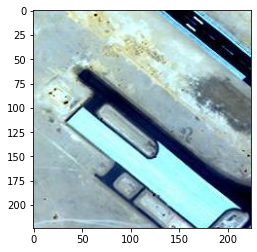

In [4]:
trainDB = currentPath + os.sep + "train20"
valDB = currentPath + os.sep + "val20"
data_set_path = currentPath + os.sep + "fMoW" + os.sep
DenseNetWeightsPretrained = currentPath + os.sep + "DenseNet-BC-161-48-no-top.h5"
model_name = "DenseNet-161"
classList = os.listdir(trainDB)

img = mpimg.imread(trainDB + os.sep + "airport" + os.sep + "airport_18_0_msrgb.jpg")
imgplot = plt.imshow(img)

In [5]:
lr = 0.00004
batch_size = 10
num_epochs = 100
pre_train_epochs = 20

num_steps_per_epoch = 4
img_rows, img_cols, img_channel = 224, 224, 3
num_categories = len(classList)

In [6]:
train_data_gen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=270,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')
    
train_generator = train_data_gen.flow_from_directory(
    directory=trainDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

val_data_gen = ImageDataGenerator(
    rescale=1. / 225,
)
val_generator = val_data_gen.flow_from_directory(
    directory=valDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 75 images belonging to 5 classes.
Found 25 images belonging to 5 classes.


In [7]:
print(train_generator.class_indices)
imgs, labels = next(train_generator)

{'airport': 0, 'airport_hangar': 1, 'airport_terminal': 2, 'amusement_park': 3, 'aquaculture': 4}


In [8]:
convcnt = 1
def bn_relu_conv(x, filters, kernel_size):
    global convcnt
    convcnt = convcnt + 1
    x = BatchNormalization(name= "batch_normalization_"+str(convcnt))(x)
    x = ReLU()(x) 
    x = Conv2D(filters, kernel_size, padding="same", name= "conv2d_"+str(convcnt), use_bias=False)(x)
    return x

In [9]:
def dense_block(tensor, k, reps):
    for _ in range(reps):
        x = bn_relu_conv(tensor, 4*k, 1)
        x = bn_relu_conv(x, k, 3)
        tensor = Concatenate()([tensor, x])
    return tensor

In [10]:
def transition_layer(x, theta):
    f = int(tensorflow.keras.backend.int_shape(x)[-1] * theta)
    x = bn_relu_conv(x, f, 1)
    x = AvgPool2D(2, strides=2, padding="same")(x)
    return x

In [11]:
def densenet_161( imageShape, weights):
    k = 48
    theta = 0.5
    repetitions = [6, 12, 36, 24]

    input = Input(shape=(imageShape))

    x = Conv2D(2*k, 7, strides=2, padding="same", name="conv2d_1", use_bias=False)(input)
    x = MaxPool2D(3, strides=2, padding="same")(x)

    for reps in repetitions:
        denseBlock = dense_block(x, k, reps)
        x = transition_layer(denseBlock, theta)

    model = Model(input, denseBlock)
    model.load_weights(weights, by_name=True)
    
    x = GlobalAvgPool2D()(denseBlock)
    output = Dense(num_categories, activation="softmax")(x)
    model = Model(input, output)
        
    return model



In [12]:
model = densenet_161((img_rows, img_cols, img_channel), DenseNetWeightsPretrained)

model.summary()
#plot_model(model, show_shapes=True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 96) 14112       input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 96)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 56, 56, 96)   384         max_pooling2d[0][0]              
____________________________________________________________________________________________

In [13]:
#optimizeFunc = SGD(learning_rate=lr, momentum=0.9, nesterov=True, decay=1e-6)
optimizeFunc = Adam(learning_rate=lr)
#model.compile(optimizer=optimizeFunc, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optimizeFunc, loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
history = model.fit_generator(
    generator=train_generator,
    validation_data=val_generator,
    steps_per_epoch=num_steps_per_epoch,
    # initial_epoch=pre_train_epochs,
    epochs=num_epochs,
    validation_steps=num_steps_per_epoch,
    callbacks=[ReduceLROnPlateau()],
    verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
4/4 [==============================] - 8s 2s/step - loss: 0.4989 - accuracy: 0.2000 - val_loss: 0.5001 - val_accuracy: 0.1714 - lr: 4.0000e-05
Epoch 2/100
4/4 [==============================] - 8s 2s/step - loss: 0.4943 - accuracy: 0.2286 - val_loss: 0.4969 - val_accuracy: 0.2667 - lr: 4.0000e-05
Epoch 3/100
4/4 [==============================] - 2s 482ms/step - loss: 0.4953 - accuracy: 0.2000 - val_loss: 0.5017 - val_accuracy: 0.2000 - lr: 4.0000e-05
Epoch 4/100
4/4 [==============================] - 2s 432ms/step - loss: 0.4880 - accuracy: 0.3429 - val_loss: 0.4997 - val_accuracy: 0.2286 - lr: 4.0000e-05
Epoch 5/100
4/4 [==============================] - 2s 465ms/step - loss: 0.4825 - accuracy: 0.4500 - val_loss: 0.4967 - val_accuracy: 0.2333 - lr: 4.0000e-05
Epoch 6/100
4/4 [==============================] - 2s 429ms/step - loss: 0.4809 - accuracy: 0.4000 - val_loss: 0.5004 - val_accuracy: 0.2000

4/4 [==============================] - 2s 487ms/step - loss: 0.2371 - accuracy: 0.8500 - val_loss: 0.4096 - val_accuracy: 0.4286 - lr: 4.0000e-05
Epoch 52/100
4/4 [==============================] - 2s 432ms/step - loss: 0.2816 - accuracy: 0.7714 - val_loss: 0.3927 - val_accuracy: 0.3714 - lr: 4.0000e-05
Epoch 53/100
4/4 [==============================] - 2s 473ms/step - loss: 0.2733 - accuracy: 0.7500 - val_loss: 0.4049 - val_accuracy: 0.3667 - lr: 4.0000e-05
Epoch 54/100
4/4 [==============================] - 2s 431ms/step - loss: 0.2731 - accuracy: 0.7143 - val_loss: 0.3893 - val_accuracy: 0.3714 - lr: 4.0000e-06
Epoch 55/100
4/4 [==============================] - 2s 487ms/step - loss: 0.2274 - accuracy: 0.7750 - val_loss: 0.3834 - val_accuracy: 0.4286 - lr: 4.0000e-06
Epoch 56/100
4/4 [==============================] - 2s 418ms/step - loss: 0.2694 - accuracy: 0.8286 - val_loss: 0.3983 - val_accuracy: 0.3667 - lr: 4.0000e-06
Epoch 57/100
4/4 [==============================] - 2s 486m

In [15]:
model.save(currentPath + os.sep + "DenseNet161Model.h5")
model.save_weights(currentPath + os.sep + "DenseNet161Weights.h5")

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


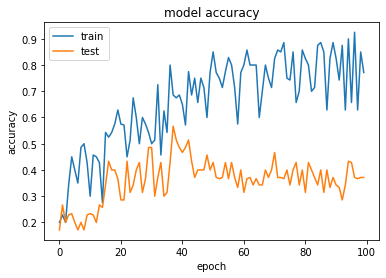

In [16]:
# Lets plot the results
print(history.history.keys())
# history accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

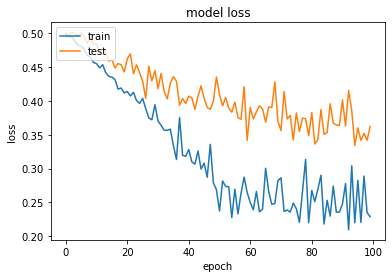

In [17]:
# history accuracy
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [18]:
# Lets predict
path = valDB + os.sep + "airport" + os.sep
imagesPredict = [f for f in listdir(path) if isfile(join(path,f))]

for file in imagesPredict:
    img = load_img(path + file, target_size=( 224, 224))
    tensorImage = img_to_array(img) /255.
    tensorImage = np.expand_dims(tensorImage, axis=0)
    prediction = model.predict(tensorImage, batch_size = 1)
    index = np.where(prediction[0] == max(prediction[0]))[0]
    if (0 != index[0].size):
        print("file "+ file + " is: " + classList[int(index[0])])

file airport_11_6_msrgb.jpg is: airport
file airport_11_7_msrgb.jpg is: airport
file airport_17_4_msrgb.jpg is: amusement_park
file airport_25_0_msrgb.jpg is: airport
file airport_3_5_msrgb.jpg is: amusement_park


In [22]:
loadedModel = load_model("DenseNet161Model.h5")

path = valDB + os.sep + "airport" + os.sep
imagesPredict = [f for f in listdir(path) if isfile(join(path,f))]
# print(imagesPredict)


for file in imagesPredict:
    img = load_img(path + file, target_size=( 224, 224))
    tensorImage = img_to_array(img) /255.
    tensorImage = np.expand_dims(tensorImage, axis=0)
    prediction = loadedModel.predict(tensorImage, batch_size = 1)
    index = np.where(prediction[0] == max(prediction[0]))[0]
    if (0 != index[0].size):
        print("file "+ file + " is: " + classList[int(index[0])])

file airport_11_6_msrgb.jpg is: airport
file airport_11_7_msrgb.jpg is: airport
file airport_17_4_msrgb.jpg is: amusement_park
file airport_25_0_msrgb.jpg is: airport
file airport_3_5_msrgb.jpg is: amusement_park
